In [2]:
%pip install sdv


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
from sdv.single_table import TVAESynthesizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sdv.metadata import Metadata

In [4]:
# Load your data
data = pd.read_csv('diabetes.csv')

# Preprocess the data (for example, standardize numeric features)
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Separate categorical columns (if any)
categorical_columns = data.select_dtypes(include=['object']).columns


In [5]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)


In [6]:


metadata = Metadata.detect_from_dataframe(
    data=data,
    table_name='diabetes table')

tvae_synthesizer = TVAESynthesizer(
    metadata, # required
    enforce_min_max_values=True,
    enforce_rounding=False,
    epochs=500
)


c:\Users\lenovo\Desktop\minor-project\streamlit-venv\Lib\site-packages\sdv\single_table\base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [19]:
tvae_synthesizer.fit(X_train)
synthetic_data = tvae_synthesizer.sample(1000)
print(synthetic_data.head())
tvae_synthesizer.save('tvae_model.pkl')

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.744519  1.323157       1.613961       1.114946  0.555471  2.415959   
1    -0.722125  0.459919       0.361323      -1.241861 -0.672145 -0.219338   
2     0.668580 -0.751298       0.146822       1.206722 -0.692891 -0.283151   
3     1.251607  1.827930       0.537560       0.822429 -0.692891 -0.125289   
4    -0.904966 -0.851968       0.034184       0.129049  0.432407 -0.410295   

   DiabetesPedigreeFunction       Age   Outcome  
0                  0.848440  1.538804  1.365896  
1                 -0.490226 -0.293209  1.357280  
2                 -0.497681 -0.080513 -0.732120  
3                  0.410600  0.645338  1.365896  
4                 -0.057049  0.426537 -0.732120  


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Prepare training data
X_synthetic = synthetic_data.drop(columns=['Outcome'])
y_synthetic = synthetic_data['Outcome'].round().astype(int)  # Fix here

# Train classifier
clf = RandomForestClassifier()
clf.fit(X_synthetic, y_synthetic)

# Prepare test data
X_real = X_test.drop(columns=['Outcome'])
y_real = X_test['Outcome'].round().astype(int)  # Fix here
y_pred = clf.predict(X_real)

# Evaluate performance
accuracy = accuracy_score(y_real, y_pred)
f1 = f1_score(y_real, y_pred)

print(f'Accuracy on Real Data: {accuracy:.2%}')
print(f'F1 Score on Real Data: {f1:.2%}')


Accuracy on Real Data: 72.73%
F1 Score on Real Data: 66.13%


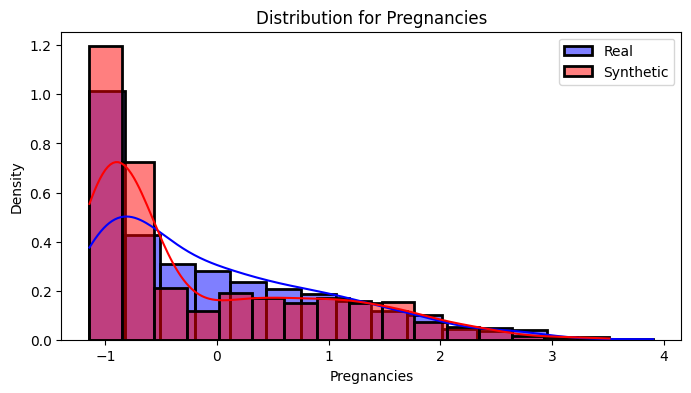

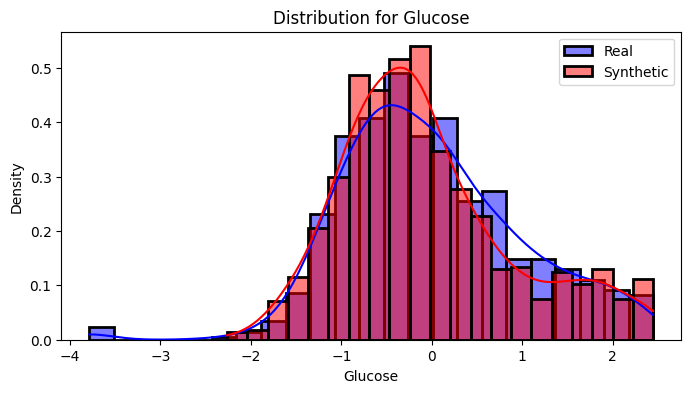

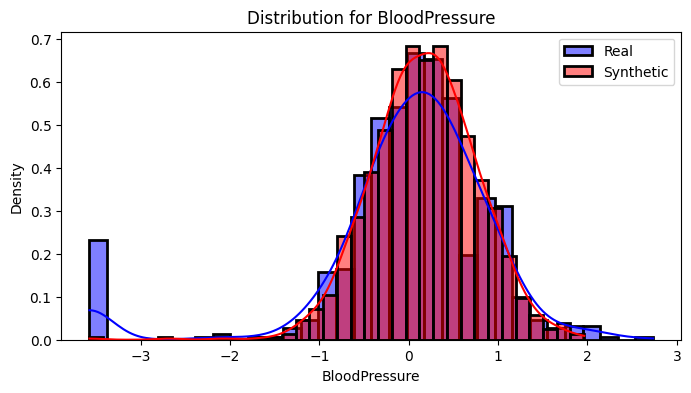

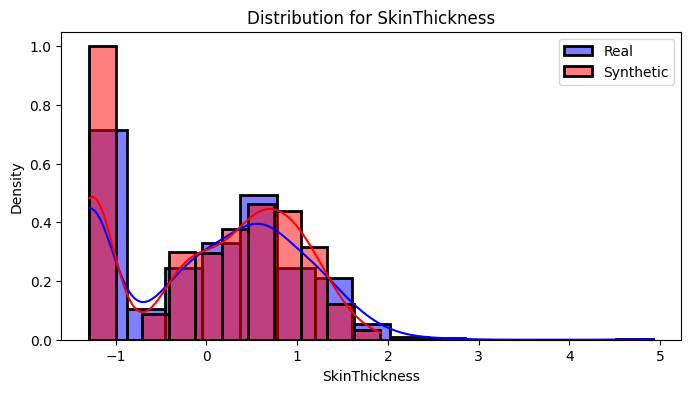

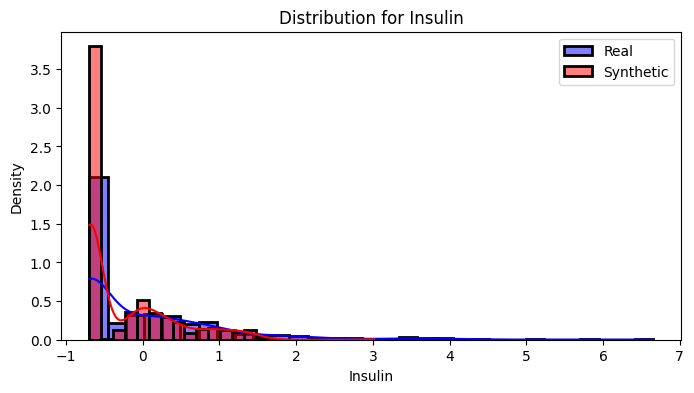

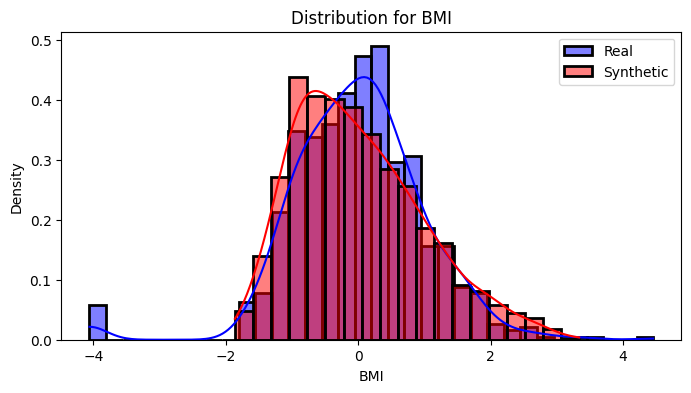

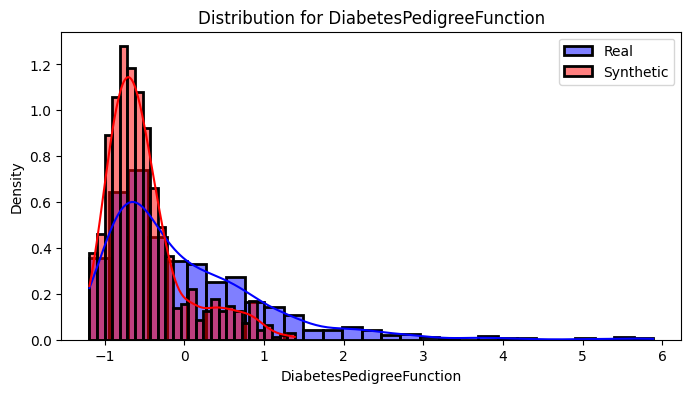

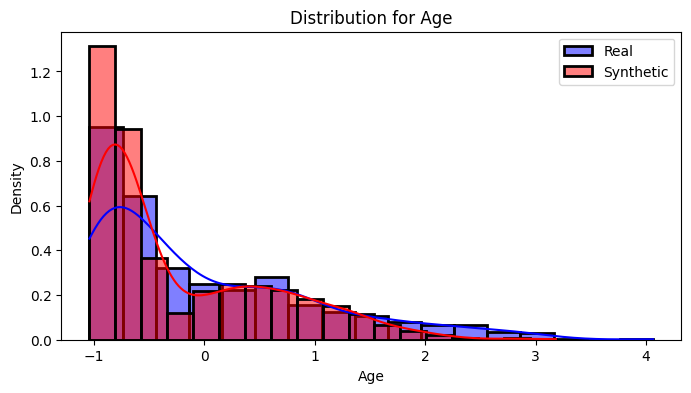

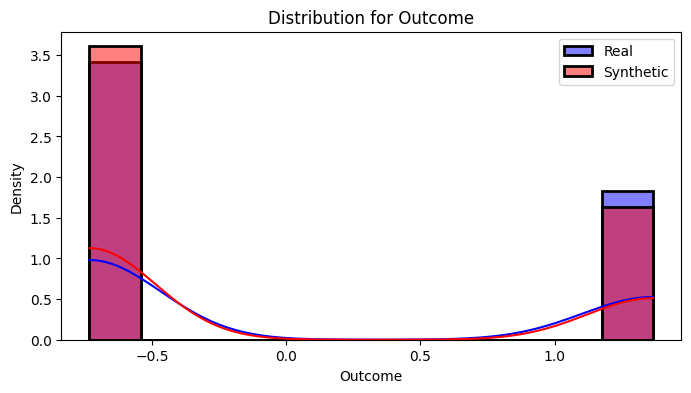

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'real_data' and 'synthetic_data' are pandas DataFrames with the same columns
columns = data.columns

for col in columns:
    plt.figure(figsize=(8, 4))
    
    sns.histplot(data[col], kde=True, label='Real', color='blue', stat='density', linewidth=2)
    sns.histplot(synthetic_data[col], kde=True, label='Synthetic', color='red', stat='density', linewidth=2)
    
    plt.title(f'Distribution for {col}')
    plt.legend()
    plt.show()


In [10]:
from scipy.stats import ks_2samp

for col in numeric_columns:
    stat, p = ks_2samp(data[col], synthetic_data[col])
    print(f'{col}: KS-stat={stat:.3f}, p-value={p:.3f}')


Pregnancies: KS-stat=0.242, p-value=0.000
Glucose: KS-stat=0.090, p-value=0.002
BloodPressure: KS-stat=0.088, p-value=0.002
SkinThickness: KS-stat=0.151, p-value=0.000
Insulin: KS-stat=0.196, p-value=0.000
BMI: KS-stat=0.085, p-value=0.003
DiabetesPedigreeFunction: KS-stat=0.283, p-value=0.000
Age: KS-stat=0.166, p-value=0.000
Outcome: KS-stat=0.464, p-value=0.000


In [18]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# 1. perform basic validity checks
diagnostic = run_diagnostic(data, synthetic_data, metadata)

# 2. measure the statistical similarity
quality_report = evaluate_quality(data, synthetic_data, metadata)
print(diagnostic.get_details(property_name='Data Structure'))
# 3. plot the data
fig = get_column_plot(
    real_data=data,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='Outcome'
)
    
plt.show()

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 1153.48it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 288.37it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 240.63it/s]|
Column Shapes Score: 80.4%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 193.86it/s]|
Column Pair Trends Score: 94.77%

Overall Score (Average): 87.58%

           Metric  Score
0  TableStructure    1.0


In [12]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Pregnancies,KSComplement,0.758312
1,Glucose,KSComplement,0.910385
2,BloodPressure,KSComplement,0.911708
3,SkinThickness,KSComplement,0.849427
4,Insulin,KSComplement,0.804021
5,BMI,KSComplement,0.914865
6,DiabetesPedigreeFunction,KSComplement,0.717323
7,Age,KSComplement,0.833625
8,Outcome,KSComplement,0.535958
